# Insurance cost prediction using linear regression

In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to **predict the price of yearly medical bills**. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from [Kaggle](https://www.kaggle.com/mirichoi0218/insurance).

## Libraries

In [1]:
import torch
import torchvision
from torchvision.datasets.utils import download_url
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import matplotlib.pyplot as plt

## Download Data

In [2]:
DATASET_URL = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

Using downloaded and verified file: ./insurance.csv


In [3]:
df_raw = pd.read_csv(DATA_FILENAME)
df_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
def customize_dataset(df_raw, rand_str):
    df = df_raw.copy(deep=True)
    # drops some rows
    df = df.sample(int(0.95*len(df)), random_state=int(ord(rand_str[0])))
    # scale input
    df.bmi = df.bmi * ord(rand_str[1])/100.
    # scale target
    df.charges = df.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        df = df.drop(['region'], axis=1)
    return df

In [5]:
your_name = "anh-tuan"
df = customize_dataset(df_raw, your_name)
df.head()

,age,sex,bmi,children,smoker,charges
27,55,female,36.0525,2,no,12759.377540
997,63,female,40.5350,0,no,14443.487240
162,54,male,43.5600,1,no,10868.574080
824,60,male,26.7520,0,no,13024.548992
392,48,male,34.5895,1,no,9322.622972


## Explorer Data

In [6]:
df.shape

(1271, 6)

In [7]:
df['charges'].describe()

count     1271.000000
mean     13846.763118
std      12656.316203
min       1166.748856
25%       4942.447536
50%       9766.999840
75%      17111.433326
max      66321.245130
Name: charges, dtype: float64

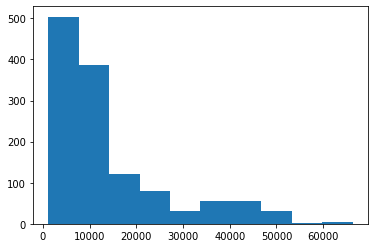

In [8]:
plt.hist(df.charges);

## Prepare Data For Training

In [9]:
def df_to_arrays(df, input_cols, cat_cols, output_cols):
    # make a copy of the original dataframe
    df1 = df.copy(deep=True)
    # convert non-numeric categorical columns to numbers
    for col in cat_cols:
        df1[col] = df1[col].astype('category').cat.codes
    # extract input & output arrays as numpy arrays
    inputs_array = df1[input_cols].to_numpy()
    targets_array = df1[output_cols].to_numpy()
    return inputs_array, targets_array

In [10]:
input_cols = ['age', 'sex', 'bmi', 'children', 'smoker']
cat_cols = ['sex', 'smoker']
output_cols = ['charges']

In [11]:
inputs, targets = df_to_arrays(df, input_cols, cat_cols, output_cols)
inputs, targets

(array([[55.    ,  0.    , 36.0525,  2.    ,  0.    ],
        [63.    ,  0.    , 40.535 ,  0.    ,  0.    ],
        [54.    ,  1.    , 43.56  ,  1.    ,  0.    ],
        ...,
        [58.    ,  1.    , 35.211 ,  1.    ,  0.    ],
        [32.    ,  0.    , 48.642 ,  0.    ,  0.    ],
        [35.    ,  1.    , 19.646 ,  1.    ,  0.    ]]),
 array([[12759.37754 ],
        [14443.48724 ],
        [10868.57408 ],
        ...,
        [12424.490936],
        [ 4153.944912],
        [ 5321.160416]]))

In [12]:
X = torch.from_numpy(inputs.astype('float32'))
Y = torch.from_numpy(targets.astype('float32'))
X.dtype, Y.dtype

(torch.float32, torch.float32)

In [13]:
val_percent = 0.15
ds_size = X.shape[0]
val_size = int(ds_size*val_percent)
train_size = ds_size - val_size
print("ds_size = {}: train_size = {}, val_size = {}".format(ds_size, train_size, val_size))

ds_size = 1271: train_size = 1081, val_size = 190


In [14]:
dataset = TensorDataset(X, Y)
train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [15]:
batch_size = 95
train_loader = DataLoader(train_ds, batch_size*2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [16]:
for batch in train_loader:
    Xb, Yb = batch
    print(Xb)
    print(Yb)
    break

tensor([[51.0000,  0.0000, 40.7550,  3.0000,  1.0000],
        [47.0000,  1.0000, 39.8090,  0.0000,  1.0000],
        [18.0000,  0.0000, 23.8260,  0.0000,  1.0000],
        [25.0000,  0.0000, 22.8800,  1.0000,  0.0000],
        [56.0000,  0.0000, 46.1010,  0.0000,  0.0000],
        [21.0000,  0.0000, 24.3485,  0.0000,  0.0000],
        [19.0000,  1.0000, 30.3600,  0.0000,  0.0000],
        [59.0000,  1.0000, 45.2540,  1.0000,  1.0000],
        [64.0000,  0.0000, 34.4300,  2.0000,  1.0000],
        [61.0000,  1.0000, 26.0205,  0.0000,  0.0000],
        [57.0000,  0.0000, 26.3780,  1.0000,  0.0000],
        [37.0000,  1.0000, 32.8130,  2.0000,  0.0000],
        [38.0000,  1.0000, 30.8275,  1.0000,  0.0000],
        [38.0000,  0.0000, 30.3600,  0.0000,  0.0000],
        [53.0000,  0.0000, 29.2600,  0.0000,  0.0000],
        [32.0000,  0.0000, 32.7800,  2.0000,  0.0000],
        [36.0000,  1.0000, 31.4545,  3.0000,  0.0000],
        [53.0000,  1.0000, 37.5155,  0.0000,  1.0000],
        [4

## Create a Linear Regression Model

In [17]:
def normalize(X):
    mn = X.min(dim=0)[0]
    mx = X.max(dim=0)[0]
    X = (X-mn)/(mx-mn)
    return X

In [18]:
class InsuranceModel(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.linear = nn.Linear(in_features, out_classes)
    
    def forward(self, X):
        Y_hat = self.linear(normalize(X))
        return Y_hat
    
    def cost(self, batch):
        X, Y = batch
        Y_hat = self(X)
        cost = F.mse_loss(Y_hat, Y)
        return cost
    
    def evaluate(self, batch):
        X, Y = batch
        Y_hat = self(X)
        cost = F.mse_loss(Y_hat.detach(), Y)
        log = {'cost': cost}
        return log

## Train model

In [19]:
def evaluate_epoch(batch_logs):
    batch_costs = [log['cost'] for log in batch_logs]
    epoch_cost = sum(batch_costs)/len(batch_costs)
    log = {'cost': epoch_cost}
    return log

In [20]:
def fit(epochs, model, lr, opt_func, train_loader, val_loader):
    optimizer = opt_func(model.parameters(), lr=lr)
    logs = list()
    for i in range(epochs):
        # training phase
        for batch in train_loader:
            cost = model.cost(batch)
            cost.backward()
            optimizer.step()
            optimizer.zero_grad()
        # validation phase
        batch_logs = [model.evaluate(batch) for batch in val_loader]
        epoch_log = evaluate_epoch(batch_logs)
        logs.append(epoch_log)
        # print log
        if ((i+1)%20 == 0) or (i == epochs-1):
            print("epoch {}: cost = {}".format(i+1, epoch_log['cost']))
    return logs

In [21]:
m, in_features = X.shape
_, out_classes = Y.shape
print("in_features = {}, out_classes = {}".format(in_features, out_classes))
print("nubmer of samples = {}".format(m))

in_features = 5, out_classes = 1
nubmer of samples = 1271


In [22]:
model = InsuranceModel(in_features, out_classes)
opt_func = torch.optim.SGD

In [23]:
epochs = 100
lr = 1e-2
logs = fit(epochs, model, lr, opt_func, train_loader, val_loader)

/home/tuanva/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


epoch 20: cost = 96586232.0
epoch 40: cost = 69157792.0
epoch 60: cost = 55494784.0
epoch 80: cost = 48425700.0
epoch 100: cost = 44566684.0


In [24]:
epochs = 100
lr = 1e-3
l = fit(epochs, model, lr, opt_func, train_loader, val_loader)
logs.extend(l)

epoch 20: cost = 44289156.0
epoch 40: cost = 44025484.0
epoch 60: cost = 43779376.0
epoch 80: cost = 43548424.0
epoch 100: cost = 43320360.0


In [25]:
epochs = 100
lr = 1e-4
l = fit(epochs, model, lr, opt_func, train_loader, val_loader)
logs.extend(l)

epoch 20: cost = 43299044.0
epoch 40: cost = 43278080.0
epoch 60: cost = 43256968.0
epoch 80: cost = 43236000.0
epoch 100: cost = 43215180.0


In [26]:
epochs = 100
lr = 1e-5
l = fit(epochs, model, lr, opt_func, train_loader, val_loader)
logs.extend(l)

epoch 20: cost = 43213080.0
epoch 40: cost = 43210952.0
epoch 60: cost = 43208864.0
epoch 80: cost = 43206800.0
epoch 100: cost = 43204696.0


In [27]:
epochs = 100
lr = 1e-6
l = fit(epochs, model, lr, opt_func, train_loader, val_loader)
logs.extend(l)

epoch 20: cost = 43204488.0
epoch 40: cost = 43204280.0
epoch 60: cost = 43204096.0
epoch 80: cost = 43203888.0
epoch 100: cost = 43203704.0


In [28]:
for i in range(len(logs)-1):
    if logs[i]['cost'] < logs[i+1]['cost']:
        print("i = {}: {}, {}".format(i, logs[i]['cost'].item(), logs[i+1]['cost'].item()))
        break

## Make predictions

In [29]:
x, y = val_ds[0]
yh = model(x)
cost = model.evaluate((x, y))['cost']
print("x = {}, y = {}".format(x.tolist(), round(y.item(),2)))
print("predict = {}, cost = {}".format(round(yh.item(),2), round(cost.item(),2)))

x = [43.0, 0.0, 35.816001892089844, 3.0, 1.0], y = 42578.94
predict = 16713.07, cost = 669042880.0


In [30]:
x, y = val_ds[10]
yh = model(x)
cost = model.evaluate((x, y))['cost']
print("x = {}, y = {}".format(x.tolist(), round(y.item(),2)))
print("predict = {}, cost = {}".format(round(yh.item(),2), round(cost.item(),2)))

x = [18.0, 1.0, 19.018999099731445, 2.0, 1.0], y = 13342.63
predict = 16521.68, cost = 10106333.0


In [31]:
x, y = val_ds[23]
yh = model(x)
cost = model.evaluate((x, y))['cost']
print("x = {}, y = {}".format(x.tolist(), round(y.item(),2)))
print("predict = {}, cost = {}".format(round(yh.item(),2), round(cost.item(),2)))

x = [29.0, 1.0, 37.84000015258789, 0.0, 1.0], y = 37645.61
predict = 15414.62, cost = 494216576.0


In [32]:
list(model.parameters())

[Parameter containing:
 tensor([[ 8832.4561,  -196.6887,  5016.0581,  1954.3612, 21588.1621]],
        requires_grad=True),
 Parameter containing:
 tensor([3064.1909], requires_grad=True)]